## Feature extraction with pre-trained networks

### Download the 'symbol.json' and '.params from https://mxnet.apache.org/model_zoo/index.html

In [1]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'squeezenet/squeezenet_v1.1-0000.params'),
 mx.test_utils.download(path+'squeezenet/squeezenet_v1.1-symbol.json')]

C:\Users\Harini Pravin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['squeezenet_v1.1-0000.params', 'squeezenet_v1.1-symbol.json']

Next, we load the downloaded model. 

In [2]:
# set the context on CPU, switch to GPU if there is one available
ctx = mx.cpu()

In [3]:
sym, arg_params, aux_params = mx.model.load_checkpoint('squeezenet_v1.1', 0)
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

## Predicting

We first define helper functions for downloading an image and performing the
prediction:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image. Remove query string from the file name.
    fname = mx.test_utils.download(url, fname=url.split('/')[-1].split('?')[0])
    img = mx.image.imread(fname)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = mx.image.imresize(img, 224, 224) # resize
    img = img.transpose((2, 0, 1)) # Channel first
    img = img.expand_dims(axis=0) # batchify
    img = img.astype('float32') # for gpu context
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([img]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

Now, we can perform prediction with any downloadable URL:

## Feature extraction

By feature extraction, we mean presenting the input images by the output of an internal layer rather than the last softmax layer. These outputs, which can be viewed as the feature of the raw input image, can then be used by other applications such as object detection.

We can use the ``get_internals`` method to get all internal layers from a Symbol.

In [48]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['fire9_concat_output',
 'drop9_output',
 'conv10_weight',
 'conv10_bias',
 'conv10_output',
 'relu_conv10_output',
 'pool10_output',
 'flatten_output',
 'prob_label',
 'prob_output']

### Find the flatten output layer and create a feature extractor

In [6]:
fe_sym = all_layers['flatten_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=ctx, label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

We can now invoke `forward` to obtain the features:

In [7]:
def get_features(img):
    fe_mod.forward(Batch([mx.nd.array(img)]))
    features=fe_mod.get_outputs()[0].asnumpy()
    return features

### Download the cats versus dogs training folder from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data (Remember the number of images is 12500 for each class)

In [8]:
# from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
from os import listdir
from os.path import isfile,join
import os

mypath=join(os.getcwd(),'train')

cats_imgs=[join(mypath,f) for f in listdir(mypath) if f.startswith('cat')]
dogs_imgs=[join(mypath,f) for f in listdir(mypath) if f.startswith('dog')]

In [9]:
print("cats: {} and dogs: {}".format(len(cats_imgs),len(dogs_imgs)))

cats: 12500 and dogs: 12500


## Extract the array of features for different number of images N= 100

In [10]:
Nmax=100
#Getting the features from flatten output layer from Nmax images.
cats_features=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [11]:
#Assigning 1 for cats and 0 for dogs.
Y_cats=np.array(Nmax*[1])
Y_dogs=np.array(Nmax*[0])

In [12]:
#the x array contains the features and y array consists of labels for cats and dogs.
X_cvd=np.vstack([cats_features,dogs_features])
Y_cvd=np.vstack([Y_cats,Y_dogs]).ravel()


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_cvd,Y_cvd,random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = [
{'penalty': ['l1'],'C': np.linspace(0.0001, 10, 5 )},
{'penalty': ['l2'],'C': np.linspace(0.0001, 10, 5 )}]


<!-- INSERT SOURCE DOWNLOAD BUTTONS -->


In [16]:
grid_bin = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
print("Test set score: {:.2f}".format(grid_bin.score(X_test,y_test)))

Test set score: 0.94


## Predicting the images from the train folder

<input>:2: DeprecationWarning: invalid escape sequence \c
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \c
<input>:3: DeprecationWarning: invalid escape sequence \d
<input>:2: DeprecationWarning: invalid escape sequence \c
<input>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-18-e83754fef39b>:2: DeprecationWarning: invalid escape sequence \c
  cat_test_path=join(os.getcwd(),'train\cat.1.jpg')
<ipython-input-18-e83754fef39b>:3: DeprecationWarning: invalid escape sequence \d
  dog_test_path=join(os.getcwd(),'train\dog.1.jpg')


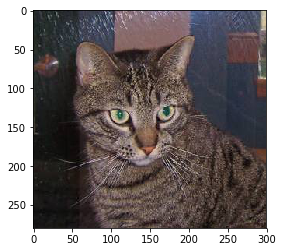

In [18]:
import matplotlib.image as mpimg
cat_test_path=join(os.getcwd(),'train\cat.1.jpg')
dog_test_path=join(os.getcwd(),'train\dog.1.jpg')
img=mpimg.imread(cat_test_path)
imgplot=plt.imshow(img)
plt.show()

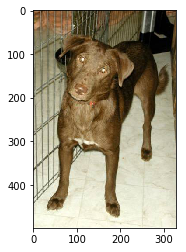

In [19]:
img=mpimg.imread(dog_test_path)
imgplot=plt.imshow(img)
plt.show()

In [20]:
features_out=get_features(get_image(cat_test_path))
prob=grid_bin.predict_proba(features_out)
pred=grid_bin.predict(features_out)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[6.43982312e-09 9.99999994e-01]] and prediction: cat


## Extract the array of features for different number of images N= 1000

In [21]:
Nmax=1000
cats_features=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [22]:
Y_cats=np.array(Nmax*[1])
Y_dogs=np.array(Nmax*[0])

In [23]:
X_cvd=np.vstack([cats_features,dogs_features])
Y_cvd=np.vstack([Y_cats,Y_dogs]).ravel()

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_cvd,Y_cvd,random_state=42)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [26]:
param_grid = [
{'penalty': ['l1'],'C': np.linspace(0.0001, 10, 5 )},
{'penalty': ['l2'],'C': np.linspace(0.0001, 10, 5 )}]

In [27]:
grid_bin = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
print("Test set score: {:.2f}".format(grid_bin.score(X_test,y_test)))

Test set score: 0.95


##  Extract the array of features for different number of images N= 5000

In [29]:
Nmax=5000
cats_features=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [30]:
Y_cats=np.array(Nmax*[1])
Y_dogs=np.array(Nmax*[0])

In [31]:
X_cvd=np.vstack([cats_features,dogs_features])
Y_cvd=np.vstack([Y_cats,Y_dogs]).ravel()

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_cvd,Y_cvd,random_state=42)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [35]:
param_grid = [
{'penalty': ['l1'],'C': np.linspace(0.0001, 10, 5 )},
{'penalty': ['l2'],'C': np.linspace(0.0001, 10, 5 )}]

In [36]:
grid_bin = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
print("Test set score: {:.2f}".format(grid_bin.score(X_test,y_test)))

Test set score: 0.95


## Extract the array of features for different number of images N= 12500

In [38]:
Nmax=12500 
cats_features=[get_features(get_image(img)).ravel() for img in cats_imgs[:Nmax]]
dogs_features=[get_features(get_image(img)).ravel() for img in dogs_imgs[:Nmax]]

In [39]:
Y_cats=np.array(Nmax*[1])
Y_dogs=np.array(Nmax*[0])

In [40]:
X_cvd=np.vstack([cats_features,dogs_features])
Y_cvd=np.vstack([Y_cats,Y_dogs]).ravel()

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_cvd,Y_cvd,random_state=42)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [44]:
param_grid = [
{'penalty': ['l1'],'C': np.linspace(0.0001, 10, 5 )},
{'penalty': ['l2'],'C': np.linspace(0.0001, 10, 5 )}]

In [46]:
grid_bin3 = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_bin3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ['l1'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}, {'penalty': ['l2'], 'C': array([1.00000e-04, 2.50008e+00, 5.00005e+00, 7.50002e+00, 1.00000e+01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
print("Test set score: {:.2f}".format(grid_bin3.score(X_test,y_test)))

Test set score: 0.96


## Predicting the images from test folder

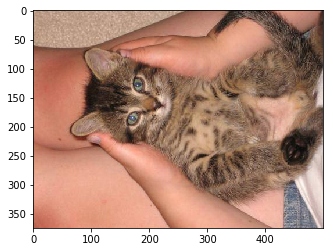

In [51]:
import matplotlib.image as mpimg
cat_test_path=join(os.getcwd(),'test\\test\\6.jpg')
dog_test_path=join(os.getcwd(),'test\\test\\1.jpg')
img=mpimg.imread(cat_test_path)
imgplot=plt.imshow(img)
plt.show()

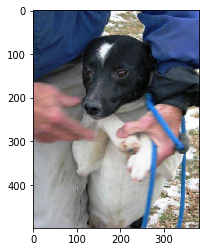

In [52]:
img=mpimg.imread(dog_test_path)
imgplot=plt.imshow(img)
plt.show()

In [55]:
features_out=get_features(get_image(dog_test_path))
prob=grid_bin.predict_proba(features_out)
pred=grid_bin.predict(features_out)

if pred[0]==1:
    fpred='cat'
else:
    fpred='dog'

print("prob: {} and prediction: {}".format(prob,fpred))

prob: [[0.99145311 0.00854689]] and prediction: dog
